# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

I've also provided the variable name, variable type, the measurement unit and a brief description of each variable in the dataset. The concrete compressive strength is the outcome variable for our analysis. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

## 1-Read DataSet

In [ ]:
# Install pyspark
!pip install pyspark
# import findspark
# findspark.init()
import os
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("Regreesion").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 7.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=39311a33f7e8b1d9278cec3e923a79e220fe9134c71ea60afc86240803d95597
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
You are working with 1 core(s)


In [ ]:
from google.colab import files
upload = files.upload()

Saving Concrete_Data.csv to Concrete_Data.csv


Import Dependencies

In [110]:
from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
from pyspark.sql.types import * #StringType,IntegerType
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# For pipeline development
from pyspark.ml import Pipeline 

In [111]:
df = spark.read.csv('Concrete_Data.csv', inferSchema=True, header=True)
df.show(1000)

+------+-----+------+-----+----------------+---------------+-------------+---+-----+
|cement| slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|csMPa|
+------+-----+------+-----+----------------+---------------+-------------+---+-----+
| 540.0|  0.0|   0.0|162.0|             2.5|         1040.0|        676.0| 28|79.99|
| 540.0|  0.0|   0.0|162.0|             2.5|         1055.0|        676.0| 28|61.89|
| 332.5|142.5|   0.0|228.0|             0.0|          932.0|        594.0|270|40.27|
| 332.5|142.5|   0.0|228.0|             0.0|          932.0|        594.0|365|41.05|
| 198.6|132.4|   0.0|192.0|             0.0|          978.4|        825.5|360| 44.3|
| 266.0|114.0|   0.0|228.0|             0.0|          932.0|        670.0| 90|47.03|
| 380.0| 95.0|   0.0|228.0|             0.0|          932.0|        594.0|365| 43.7|
| 380.0| 95.0|   0.0|228.0|             0.0|          932.0|        594.0| 28|36.45|
| 266.0|114.0|   0.0|228.0|             0.0|          932.0|     

In [112]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



Pandas Version for some explorations 

In [113]:
df_pandas=df.toPandas()
df_pandas

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## 2-Data Exploration

In [114]:
df_pandas.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


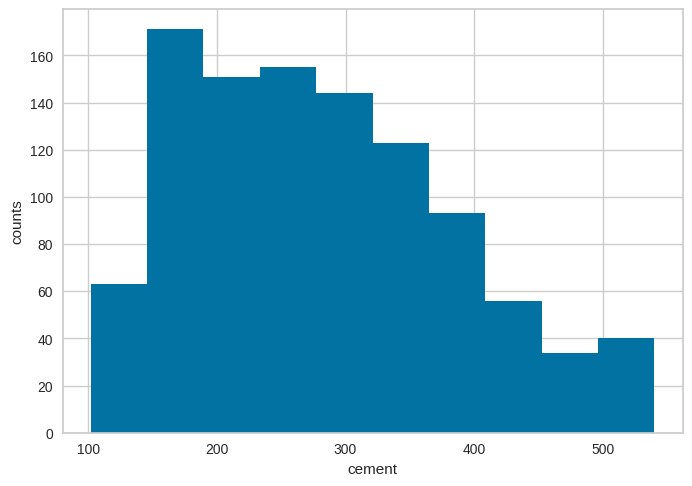

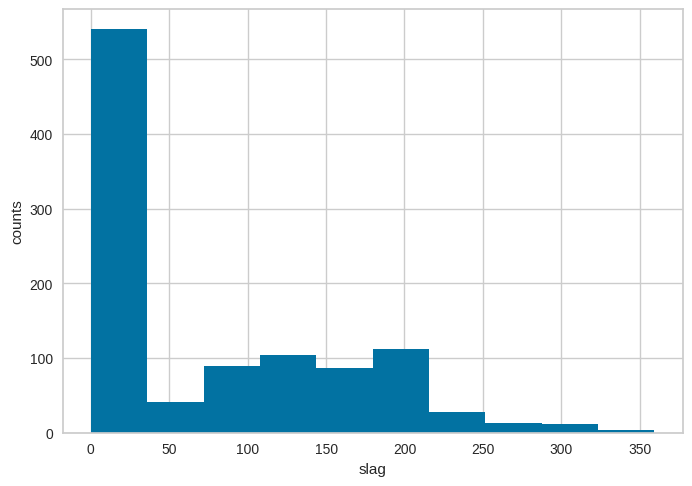

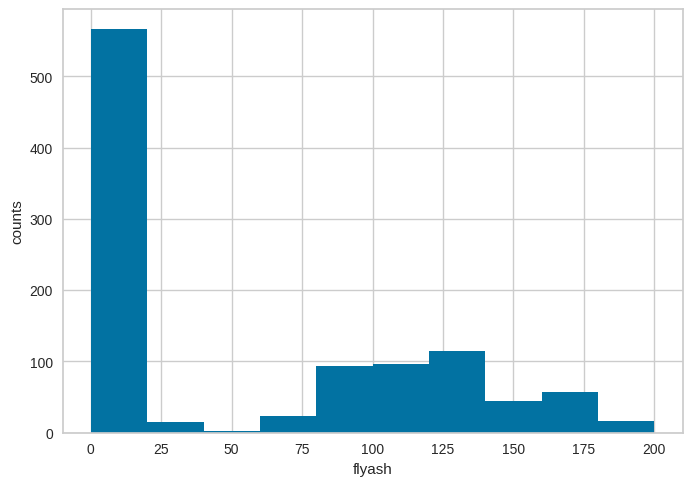

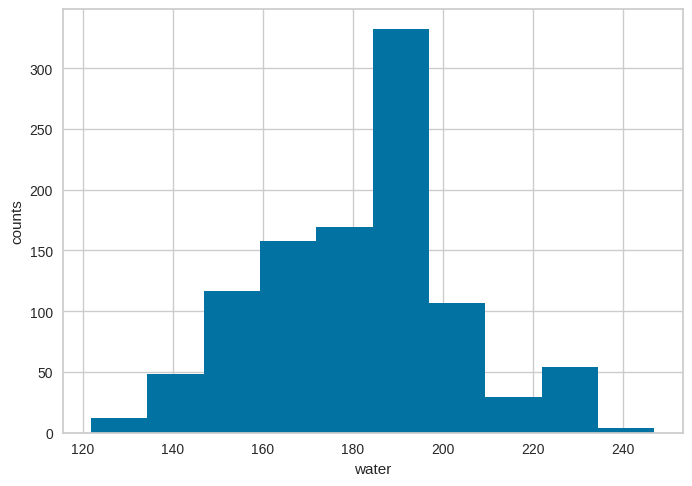

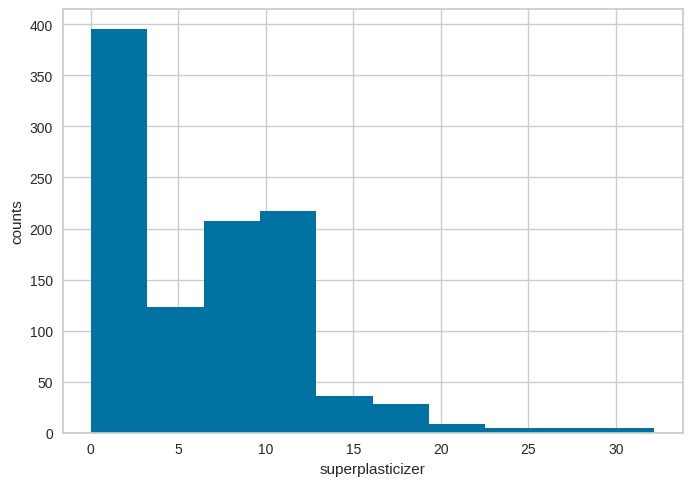

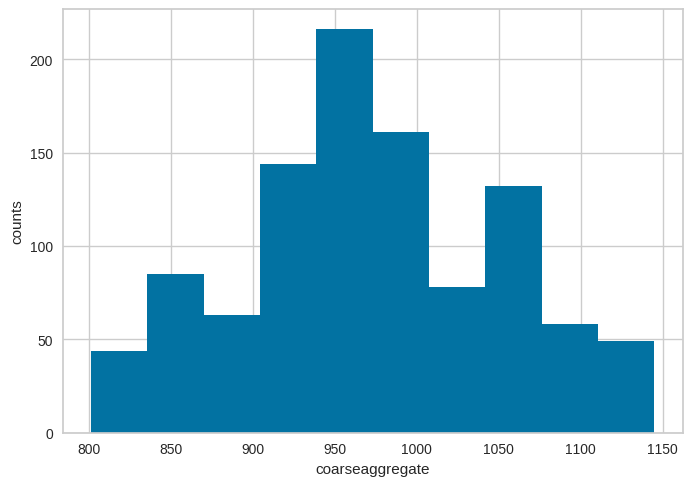

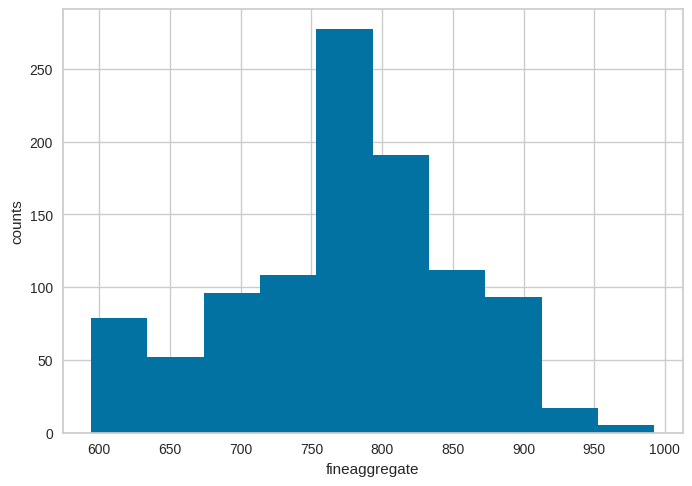

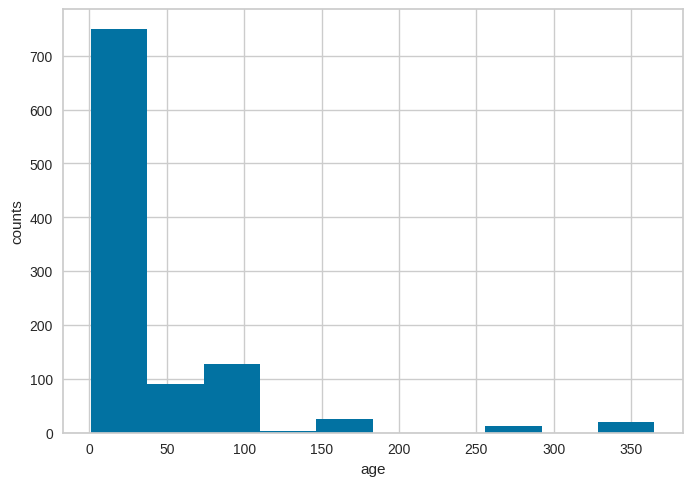

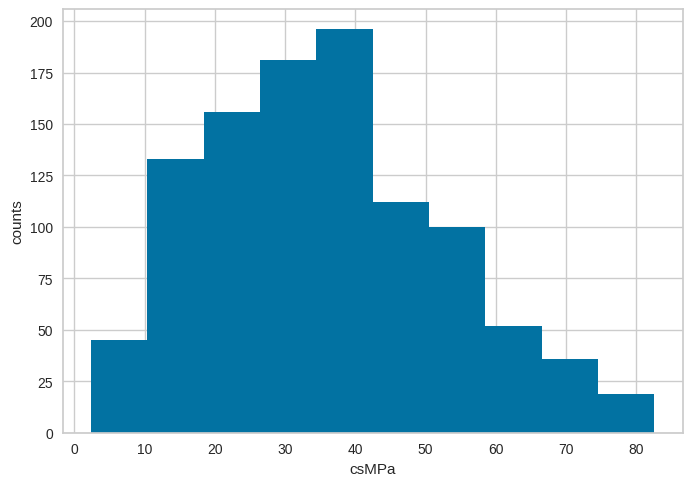

In [115]:
# explore  data distribution
for i in df_pandas.columns:
    plt.hist(df_pandas[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

### Note:
we can observe that 


*  slag--right skewed
*  flyash--right skewed
*  Super plasticizer --right skewed
*  Age --Right Skewed

so ,this skewed data would be handled in data preparation section 




In [116]:
df_pandas

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


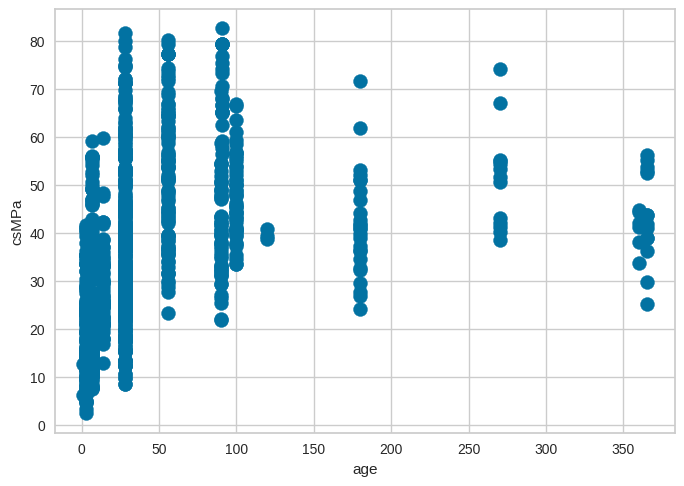

In [117]:
# Draw a scatter plot for outliers
df_pandas.plot.scatter(x = 'age', y = 'csMPa', s = 100);

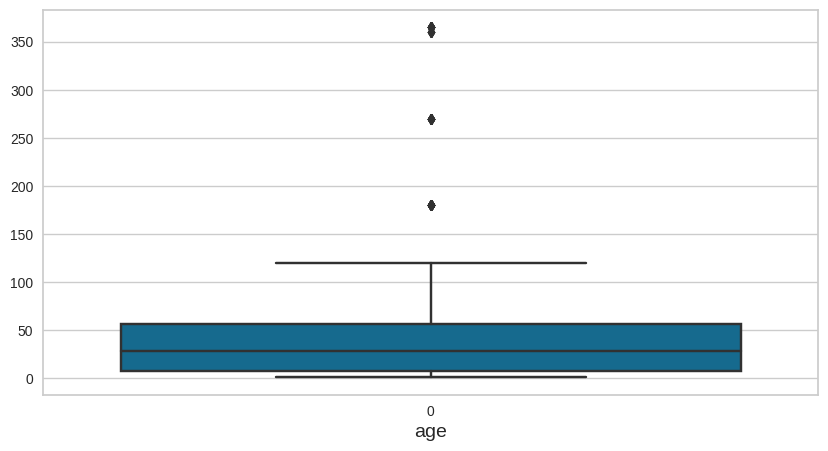

In [118]:
# explore outliers using box plot
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_pandas.age)
plt.xlabel('age', fontsize=14)
plt.show()

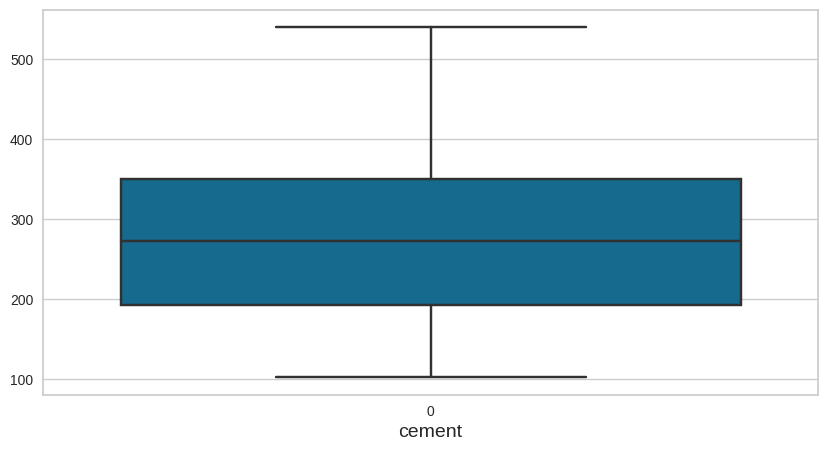

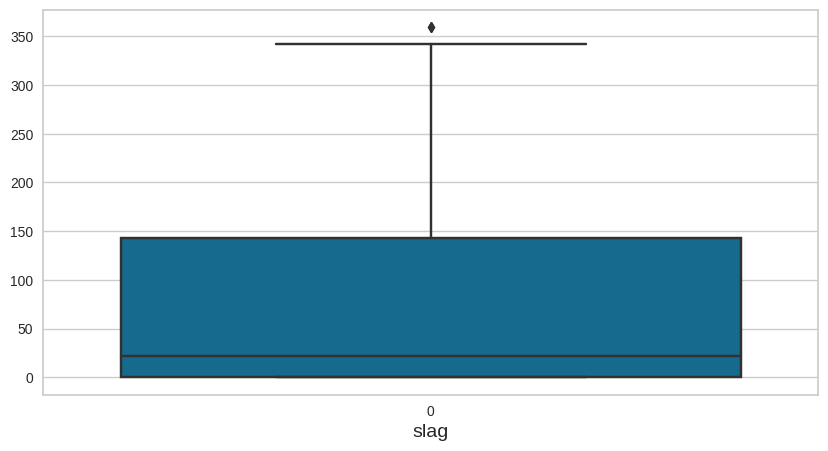

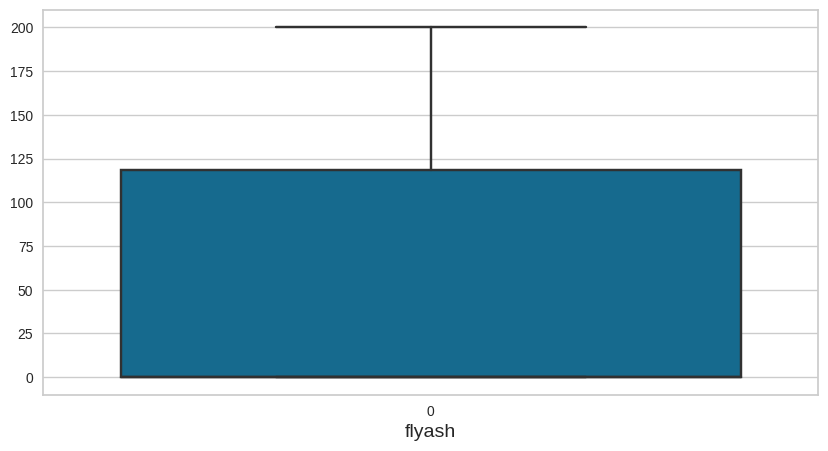

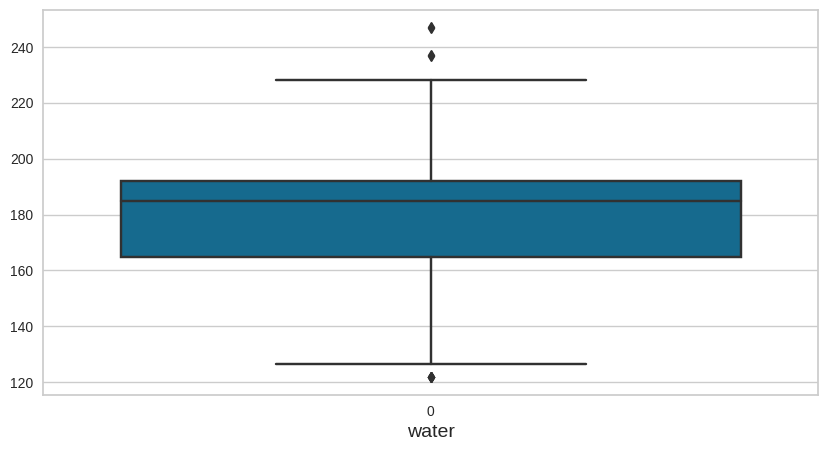

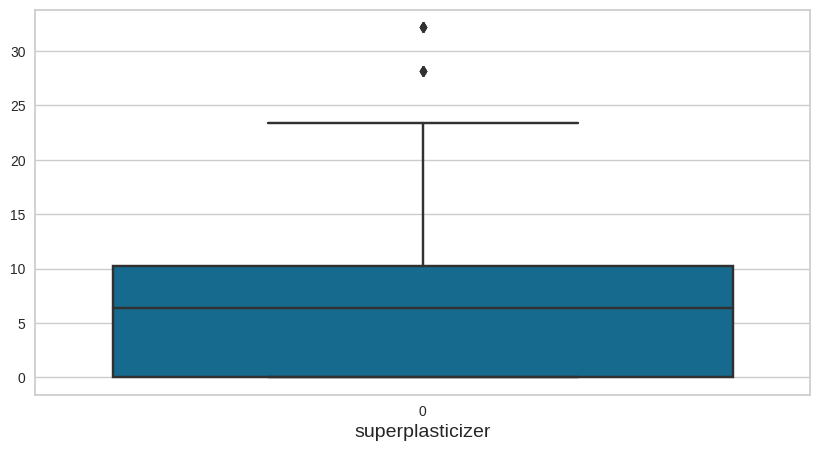

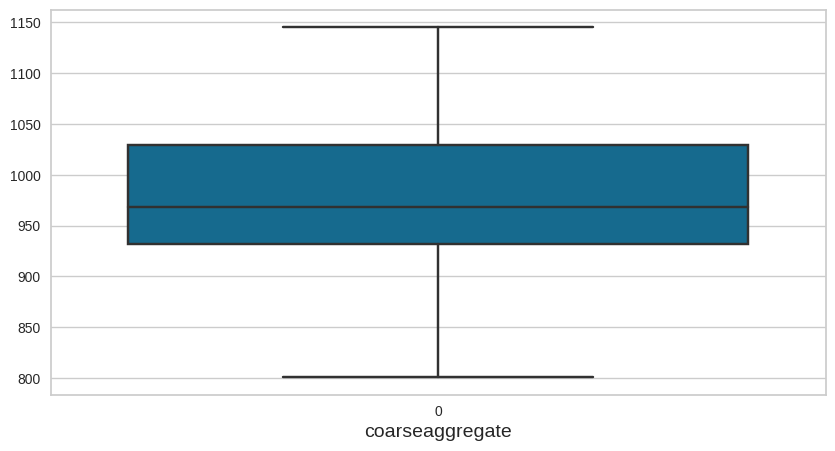

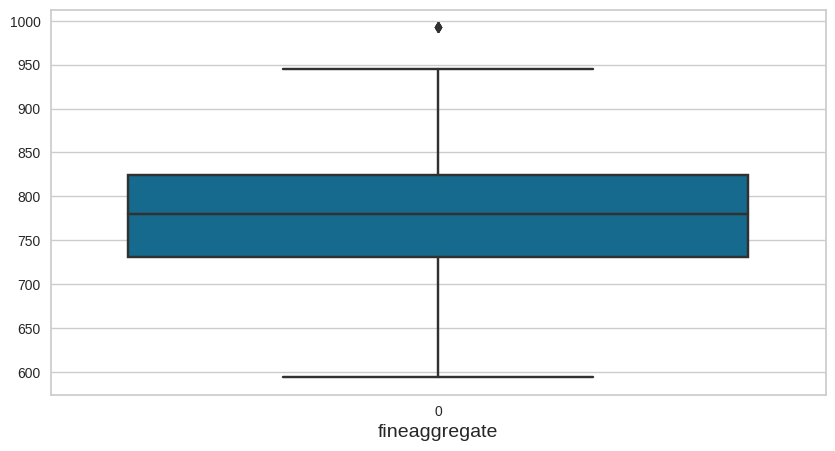

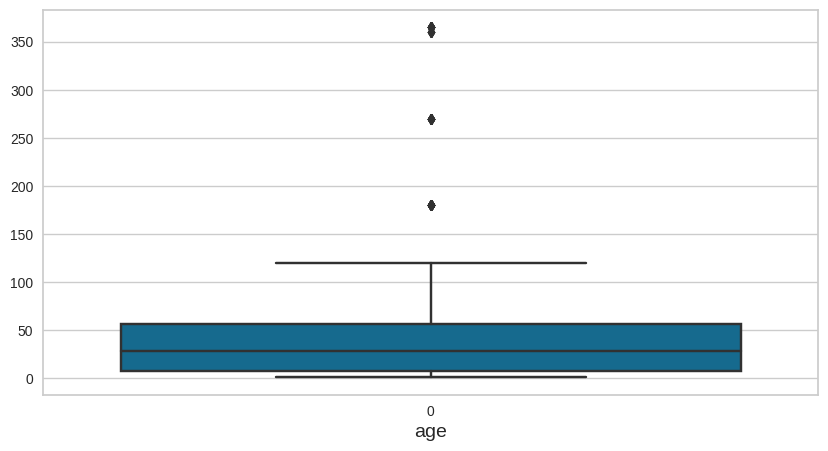

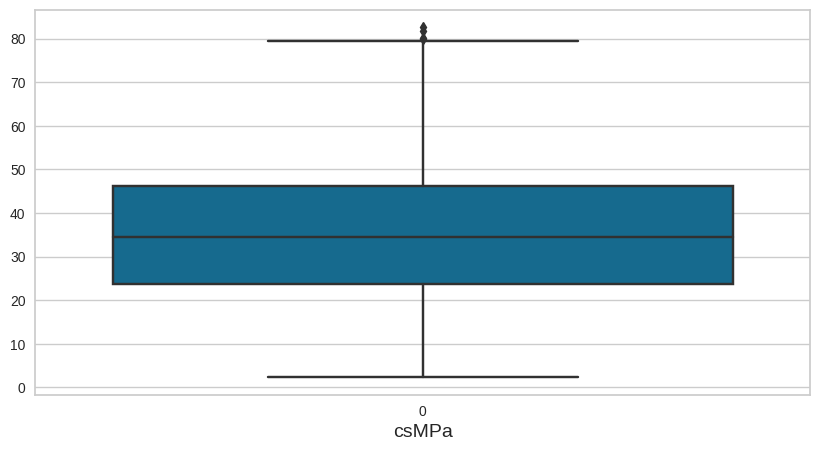

In [119]:
# explore data outliers
for i in df_pandas.columns:
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(df_pandas[i])
    plt.xlabel(i, fontsize=14)
    plt.show()

## Note:

we can observe that 

*   Water
*   superplastcizer
*   age
columns have outliers





In [120]:
# checking for duplicated Rows
num_duplicates = df.count() - df.dropDuplicates().count()
print(f"Number of duplicates: {num_duplicates}")


Number of duplicates: 25


In [121]:
# removing outliers
df= df.distinct()
print("no. of rows after removing duplicates:",df.count())

no. of rows after removing duplicates: 1005


## 2-Data Preparation :

How many null values in the data set?

In [122]:
null_counts = df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns])
null_counts.toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,0,0,0,0,0,0,0,0,0


<Axes: >

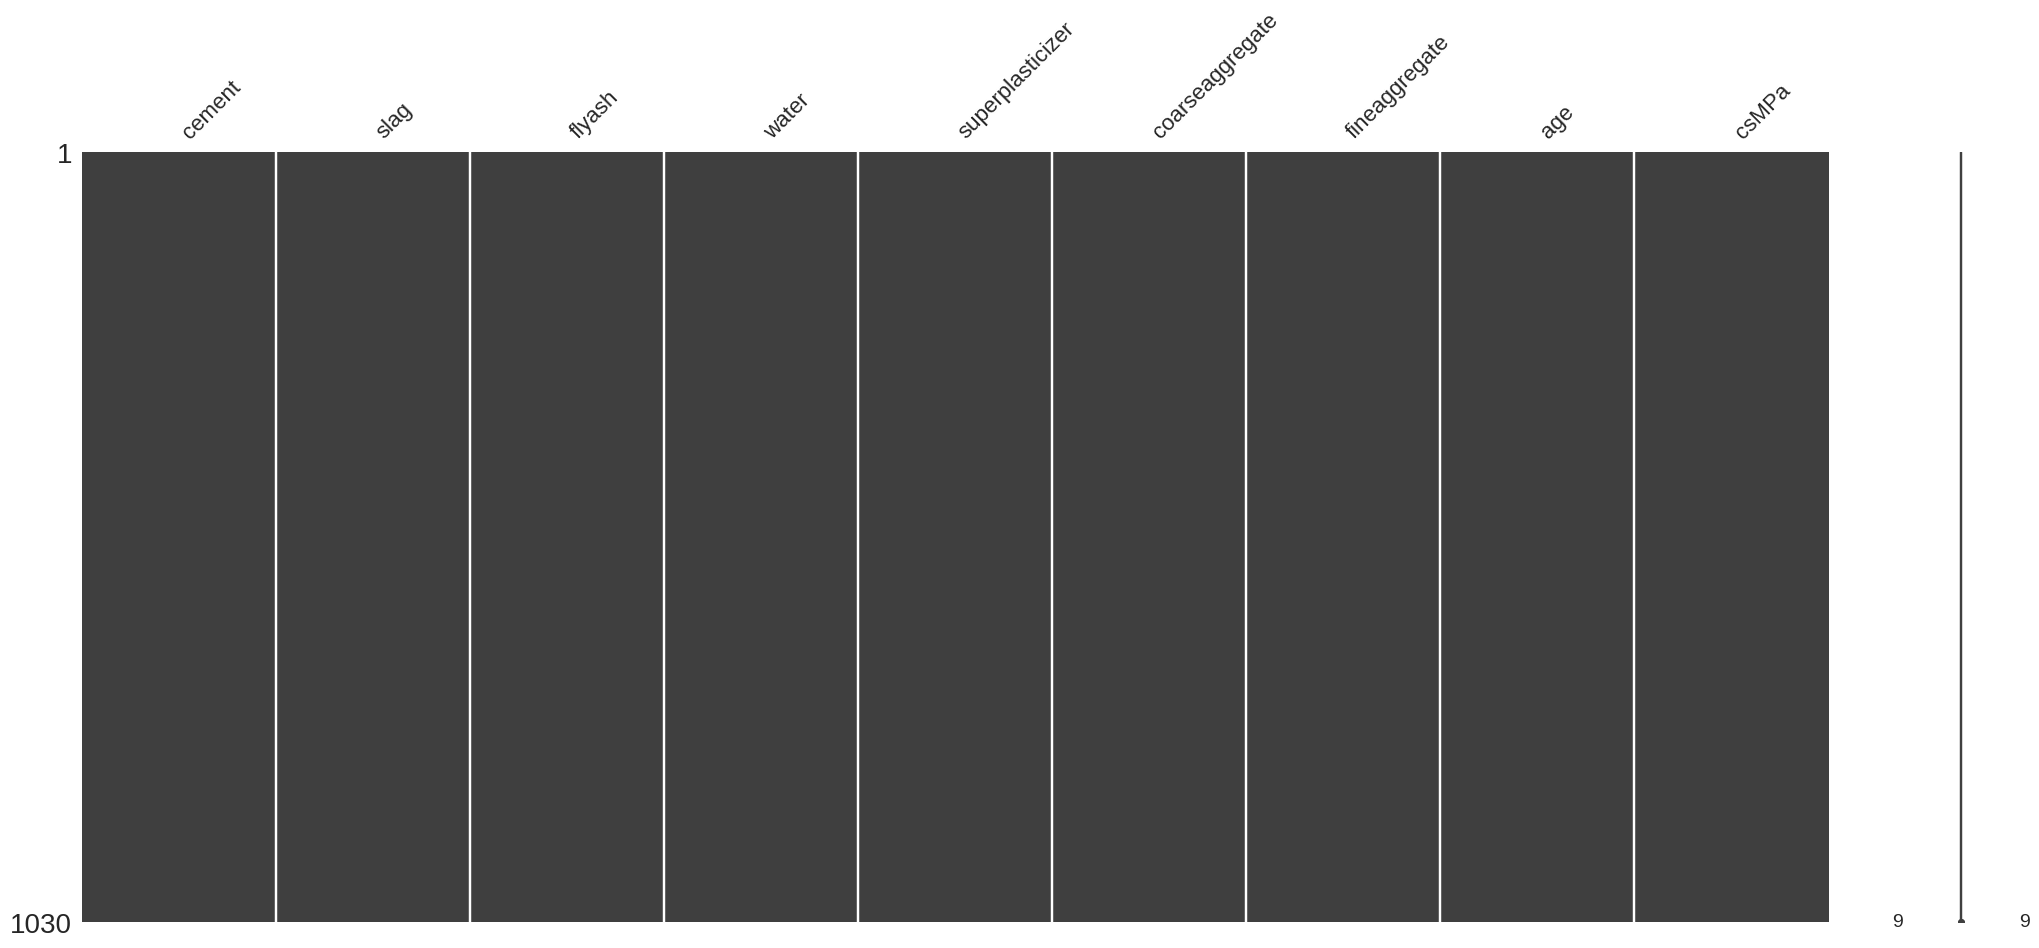

In [123]:
# plotting for missing values in data set
import missingno
missingno.matrix(df_pandas)

### Data has no missing values

## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important. 

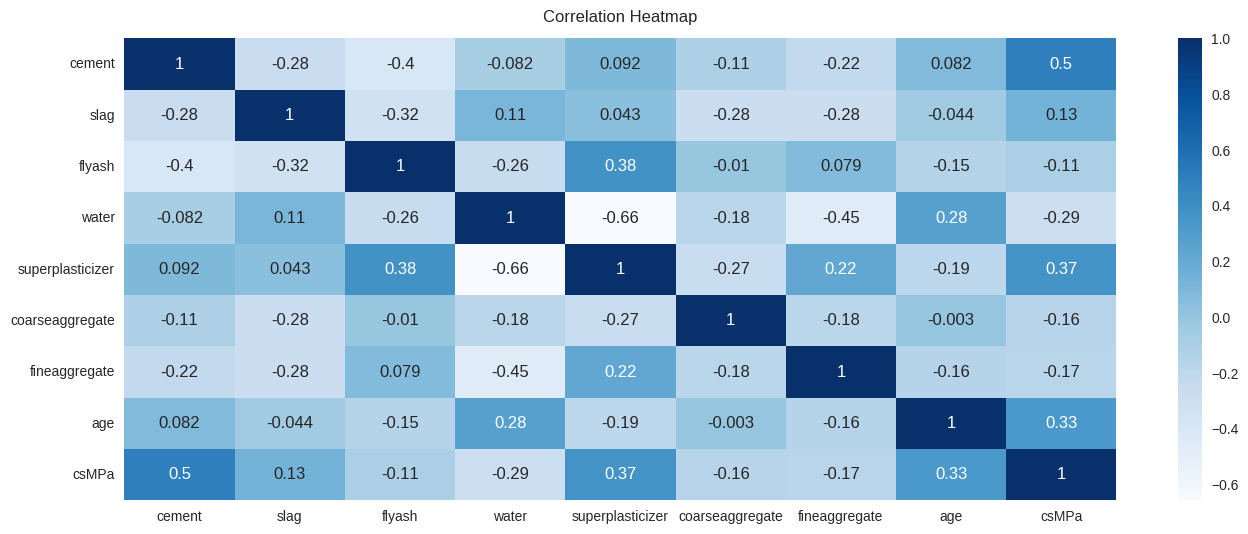

In [124]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(df_pandas.corr(), annot=True,cmap='Blues')
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

we can observe that target "csMPa" is heighly corrolated with cement (+ve)


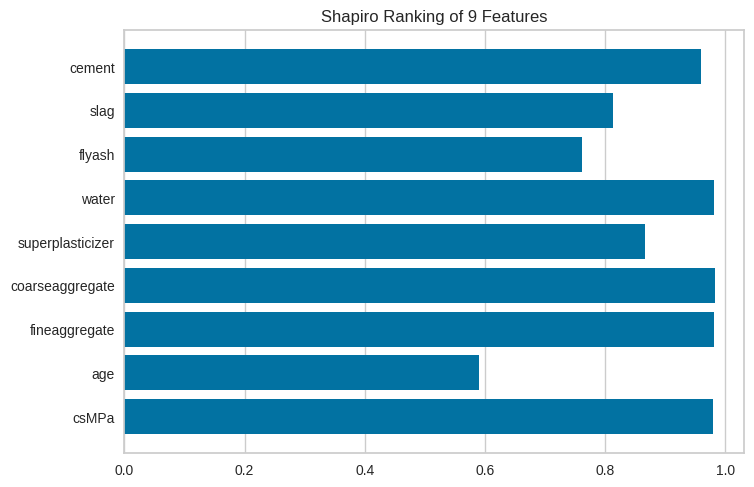

In [125]:
from yellowbrick.features import rank1d
rank1d(df_pandas);

Splitting dataframe in features and targets to illustrate the dependency between features and target column

In [126]:
target_col='csMPa'
y = df_pandas[target_col]
X = df_pandas.drop(target_col, axis=1)

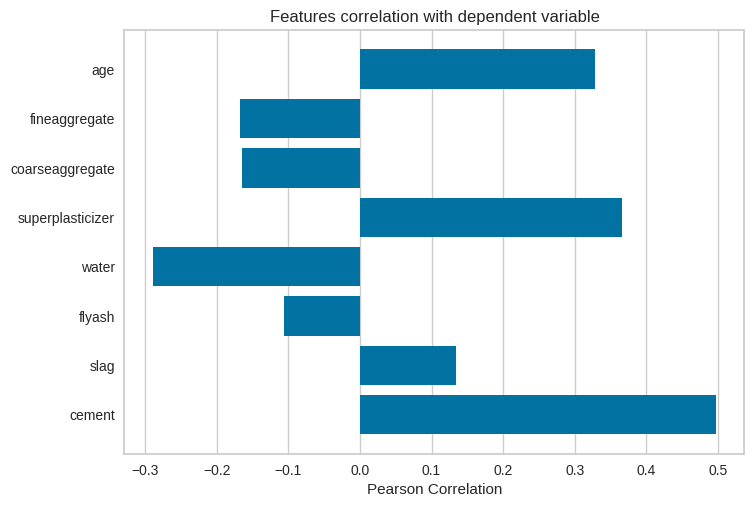

In [127]:
from yellowbrick.target.feature_correlation import feature_correlation
feature_correlation(X, y);

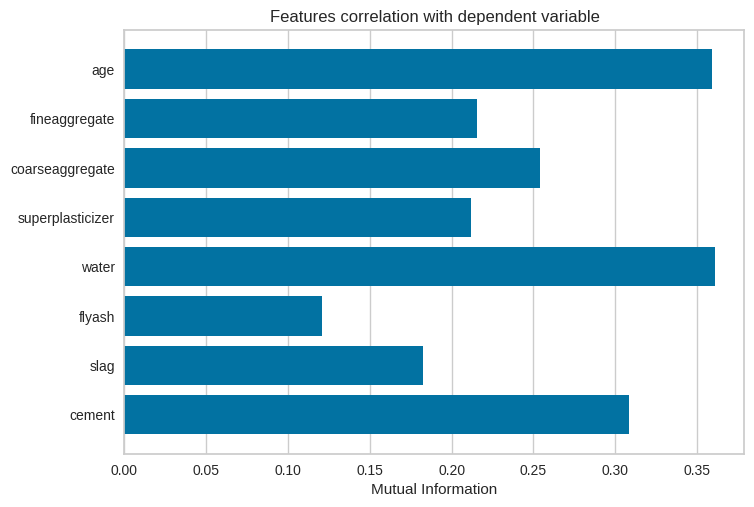

In [128]:
feature_correlation(X, y, method='mutual_info-regression');


## Feature Importance 

According to decision tree

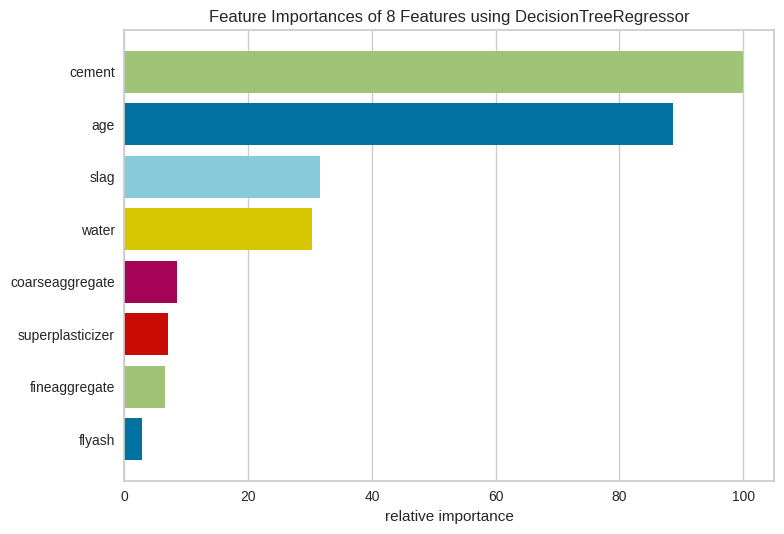

In [129]:
from yellowbrick.model_selection import feature_importances
from sklearn.tree import DecisionTreeRegressor
feature_importances(DecisionTreeRegressor(), X, y);

According to elastic regression

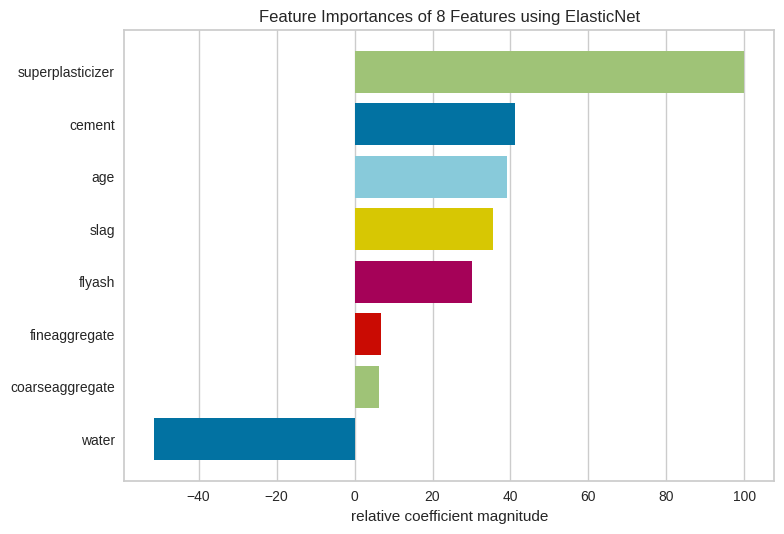

In [130]:
from sklearn.linear_model import ElasticNet
feature_importances(ElasticNet(alpha=0.01, l1_ratio=0.5), X, y);

so we can conclude that the most effective features in predicting the output is (Superplastic-Cement-age)

## Data Preparation :

## Function to Prepare the data

In [131]:
def MLRegressDFPrep(df,input_columns,dependent_var,treat_outliers=True):

    renamed = df.withColumnRenamed(dependent_var,'label')
    
    # Make sure dependent variable is numeric and change if it's not
    if str(renamed.schema['label'].dataType) != 'IntegerType':
        renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))
    
   # Convert all string type data in the input column list to numeric
    # Otherwise the Algorithm will not be able to process it
    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(renamed.schema[column].dataType) == 'StringType':
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)
            indexed = renamed
            
    if len(string_inputs) != 0: # If the datafraem contains string types
        for column in input_columns:
            if str(renamed.schema[column].dataType) == 'StringType':
                indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
                indexed = indexer.fit(renamed).transform(renamed)
    else:
        indexed = renamed
        
            
    if treat_outliers == True:
        print("We are correcting for non normality now!")
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs: 
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
        #Now fill in the values
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))
                print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
                print(col+" has been treated for negative (left) skewness. (skew =",skew,")")
                
    # Vectorize your features
    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    final_data = assembler.transform(indexed).select('features','label')
        
    return final_data

### Apply the function for the data

In [132]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler

input_columns = df.columns[0:-1]
dependent_var = 'csMPa'

final_data = MLRegressDFPrep(df,input_columns,dependent_var)
final_data.show(9)

We are correcting for non normality now!
age has been treated for positive (right) skewness. (skew =) 3.2491150251898144 )
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[475.0,0.0,0.0,22...|42.23|
|[275.1,0.0,121.4,...|56.85|
|[272.8,181.9,0.0,...|19.77|
|[173.0,116.0,0.0,...| 32.1|
|[427.5,47.5,0.0,2...| 43.7|
|[218.2,54.6,123.8...|27.42|
|[374.3,0.0,0.0,19...|39.06|
|[540.0,0.0,0.0,17...|74.17|
|[153.0,145.0,0.0,...|19.01|
+--------------------+-----+
only showing top 9 rows



## Check for Multicollinearity

Multicollinearity generally occurs when there are high correlations between two or more predictor variables (your features column in your dataframe, also called independent variables). In other words, one predictor variable can be used to predict the other. This creates redundant information, skewing the results in a regression model. 

An easy way to detect multicollinearity is to calculate correlation coefficients for all pairs of predictor variables. If the correlation coefficient, is exactly +1 or -1, this is called perfect multicollinearity, and one of the variables should be removed from the model if at all possible for the linear model to perform well.

Desicion trees on the other hand, make no assumptions on relationships between features. It just constructs splits on single features that improves classification, based on an impurity measure like Gini or entropy. If features A, B are heavily correlated, no /little information can be gained from splitting on B after having split on A. So it would typically get ignored in favor of C.

Of course a single decision tree is very vulnerable to overfitting, so one must either limit depth, prune heavily or preferly average many using an ensemble. Such problems get worse with many features and possibly also with co-variance but this problem occurs independently from multicolinearity.

MLlib offers two correlation coefficient statitics: **pearson** and **spearman**. 

**Sources:**

 - https://datascience.stackexchange.com/questions/31402/multicollinearity-in-decision-tree
 - https://www.statisticshowto.datasciencecentral.com/multicollinearity/

In [133]:
from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

In [134]:
for item in array:
    print(item[1])

-0.30332392788103046
1.0
-0.3123523496733076
0.13026211103391439
0.019800224513124635
-0.2775588679436324
-0.2896849035062942
-0.019224994051003946


In [135]:
from pyspark.ml.stat import Correlation
import pandas as pd

matrix = Correlation.corr(final_data, 'features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = input_columns, index=input_columns) 
corr_matrix_df .style.background_gradient(cmap='pink').set_precision(2)

<ipython-input-135-0d5963fe4204>:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df .style.background_gradient(cmap='pink').set_precision(2)


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.00,-0.30,-0.39,-0.06,0.06,-0.09,-0.25,0.01
slag,-0.30,1.00,-0.31,0.13,0.02,-0.28,-0.29,-0.02
flyash,-0.39,-0.31,1.00,-0.28,0.41,-0.03,0.09,-0.02
water,-0.06,0.13,-0.28,1.00,-0.65,-0.21,-0.44,0.17
superplasticizer,0.06,0.02,0.41,-0.65,1.00,-0.24,0.21,-0.05
coarseaggregate,-0.09,-0.28,-0.03,-0.21,-0.24,1.00,-0.16,-0.04
fineaggregate,-0.25,-0.29,0.09,-0.44,0.21,-0.16,1.00,-0.12
age,0.01,-0.02,-0.02,0.17,-0.05,-0.04,-0.12,1.00


## Check for Multicollinearity using Spearman using figure


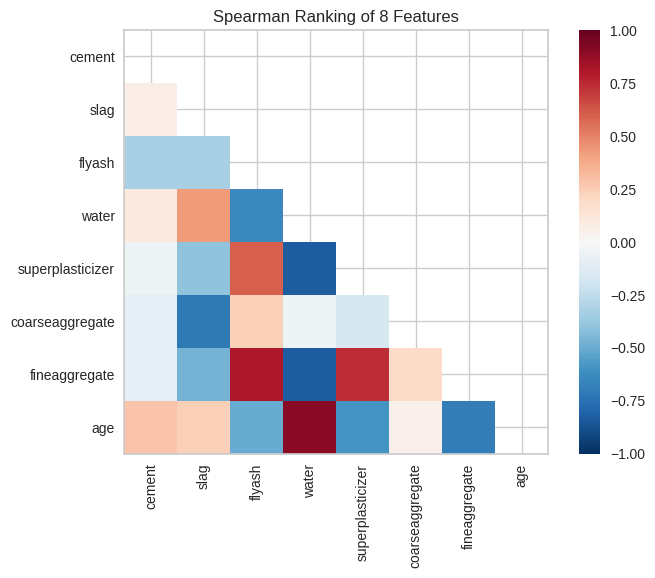

In [136]:
from yellowbrick.features import rank2d
rank2d(corr_matrix_df, algorithm='spearman');

## Check for Multicollinearity using person using figure


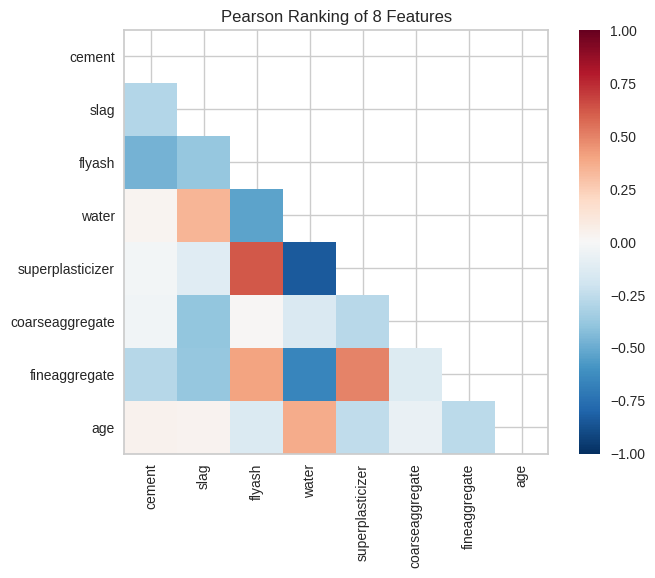

In [137]:
rank2d(corr_matrix_df, algorithm='pearson');

## 4-Training 

** Split dataframe into training and evaluation (test) dataframes**

In [138]:
train,test = final_data.randomSplit([0.7,0.3])

In [139]:
# Dependencies for this section
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Define a Function that iterativley runs through all Regression algorithms

**Note:**
We did not include Generalized Linear Regression here since it requires a much different implementation method and evaluation strategy than most regressions. 

In [140]:
def RegressTrainEval(regressor):

    def FindMtype(regressor):
        # Intstantiate Model
        M = regressor
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(regressor)
#     print('\033[1m' + Mtype + ':' + '\033[0m')


    if Mtype == "LinearRegression":
        
        #first without cross val
        fitModel = regressor.fit(train)

        # Load the Summary
        trainingSummary = fitModel.summary
        
        # Print the coefficients and intercept for linear regression
        print('\033[1m' + "Linear Regression Model Training Summary without cross validation:"+ '\033[0m')
        print(" ")
        print("Intercept: %s" % str(fitModel.intercept))
        print("")
        print("Coefficients: ")
        coeff_array = fitModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))



        # Summarize the model over the training set and print out some metrics
        print("numIterations: %d" % trainingSummary.totalIterations)
        print("objectiveHistory: (scaled loss + regularization) at each iteration \n %s" % str(trainingSummary.objectiveHistory))
        print("")
        
        # Print the Errors
        print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("Training r2: %f" % trainingSummary.r2)
        print("")
        

        # Now load the test results
        test_results = fitModel.evaluate(test)

        # And print them
        print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
        print("Test r2: {}".format(test_results.r2))
        print("")
        
        #Now train with cross val
        paramGrid = (ParamGridBuilder() \
#              .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())
        
        #Evaluator
        revaluator = RegressionEvaluator(metricName="rmse")
        
        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=revaluator,
                                  numFolds=2) # 3 is best practice
        
        print('\033[1m' + "Linear Regression Model Summary WITH cross validation:"+ '\033[0m')
        print(" ")
        # Run cross validations
        fitModel = crossval.fit(train)
        
        #save model
        global LR_BestModel 
        LR_BestModel = fitModel.bestModel
        
        print("Coefficients: ")
        coeff_array = LR_BestModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))
        
        # Get Model Summary Statistics
        ModelSummary = fitModel.bestModel.summary
        
        print("Coefficient Standard Errors: ")
        coeff_ste = ModelSummary.coefficientStandardErrors
        result = spark.createDataFrame(zip(input_columns,coeff_ste), schema=['feature','coeff std error'])
        print(result.orderBy(result["coeff std error"].desc()).show(truncate=False))
        print(" ")
        print("P Values: ") 
        # Then zip with input_columns list and create a df
        pvalues = ModelSummary.pValues
        result = spark.createDataFrame(zip(input_columns,pvalues), schema=['feature','P-Value'])
        print(result.orderBy(result["P-Value"].desc()).show(truncate=False))
        print(" ")
        
        # Use test set here so we can measure the accuracy of our model on new data
        ModelPredictions = fitModel.transform(test)
        
        # cvModel uses the best model found from the Cross Validation
        # Evaluate best model
        test_results = revaluator.evaluate(ModelPredictions)
        print('RMSE:', test_results)
    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Format results and return
        rmse_str = [str(test_results)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

    else:

        # Add parameters of your choice here:
        if Mtype in("RandomForestRegressor"):
            paramGrid = (ParamGridBuilder() \
#                            .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
                           .addGrid(regressor.numTrees, [5, 20])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("GBTRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20]) \
                         .addGrid(regressor.maxIter, [10, 15])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("DecisionTreeRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20, 40]) \
                         .build())

        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(metricName="rmse"),
                                  numFolds=2) # 3 is best practice
        # Fit Model: Run cross-validation, and choose the best set of parameters.
        fitModel = crossval.fit(train)
        
        # Get Best Model
        BestModel = fitModel.bestModel

        # FEATURE IMPORTANCES
        # Estimate of the importance of each feature.
        # Each feature’s importance is the average of its importance across all trees 
        # in the ensemble The importance vector is normalized to sum to 1. 
        print(" ")
        print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
        print("(Scores add up to 1)")
        print("Lowest score is the least important")
        print(" ")
        featureImportances = BestModel.featureImportances.toArray()
        # Convert from numpy array to list
        imp_scores = []
        for x in featureImportances:
            imp_scores.append(float(x))
        # Then zip with input_columns list and create a df
        result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
        print(result.orderBy(result["score"].desc()).show(truncate=False))
        
        #Create Global Variables for feature importances and models
        if Mtype in("DecisionTreeRegressor"):
            global DT_featureImportances
            DT_featureImportances = BestModel.featureImportances.toArray()
            global DT_BestModel 
            DT_BestModel = fitModel.bestModel
        if Mtype in("GBTRegressor"):
            global GBT_featureImportances
            GBT_featureImportances = BestModel.featureImportances.toArray()
            global GBT_BestModel 
            GBT_BestModel = fitModel.bestModel
        if Mtype in("RandomForestRegressor"):
            global RF_featureImportances
            RF_featureImportances = BestModel.featureImportances.toArray()
            global RF_BestModel 
            RF_BestModel = fitModel.bestModel
                    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Make predictions.
        predictions = fitModel.transform(test)
        # Select (prediction, true label) and compute test error
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        rmse_str = [str(rmse)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        # Clean up the Result column and output
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

In [141]:
# Run!
regressors = [
                LinearRegression()
                ,DecisionTreeRegressor()
                ,RandomForestRegressor()
                ,GBTRegressor()
                ] 
    
#set up your results table
columns = ['Regressor', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for regressor in regressors:
    new_result = RegressTrainEval(regressor)
    results = results.union(new_result)
results = results.where("Regressor!='Place Holder'")
results.show(100,False)

Linear Regression Model Training Summary without cross validation:
 
Intercept: -53.58813951301942

Coefficients: 
+----------------+--------------------+
|feature         |coeff               |
+----------------+--------------------+
|age             |9.22077785516812    |
|superplasticizer|0.16824216647001977 |
|cement          |0.12478434909411255 |
|slag            |0.10587137618083864 |
|flyash          |0.08182146999184949 |
|fineaggregate   |0.02646469586704889 |
|coarseaggregate |0.020793662034288864|
|water           |-0.16385159484540476|
+----------------+--------------------+

None
numIterations: 0
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 7.009058
Training r2: 0.818116

Test RMSE: 7.443923391768788
Test r2: 0.7799193040468502

Linear Regression Model Summary WITH cross validation:
 
Coefficients: 
+----------------+--------------------+
|feature         |coeff               |
+----------------+--------------------+
|age     

As we can observe that GBTRegressor  has the lowest RMSE =(6.006) which would make it the best performing model

And The the top important features according to GBT as follows:

*   1-Age
*   2-Cement
*   3-fineaggregate
*   4-water






Now let's see how our predictions were

## 5-Testing

In [142]:
test = final_data.limit(10)
predictions = GBT_BestModel.transform(test)
predictions = predictions.withColumn("difference",predictions.prediction-predictions.label) \
                         .withColumn("diff perct",((predictions.prediction-predictions.label)/predictions.label)*100)
print(predictions.show())
print(predictions.describe(['diff perct']).show())

+--------------------+-----+------------------+--------------------+--------------------+
|            features|label|        prediction|          difference|          diff perct|
+--------------------+-----+------------------+--------------------+--------------------+
|[475.0,0.0,0.0,22...|42.23| 42.75769645755203|  0.5276969153157012|  1.2495783117116193|
|[275.1,0.0,121.4,...|56.85| 59.63047289380819|  2.7804744196870956|  4.8908962081200515|
|[272.8,181.9,0.0,...|19.77|16.514071855755528| -3.2559286020081437| -16.469036553459166|
|[173.0,116.0,0.0,...| 32.1| 35.13703318597085|  3.0370347118497563|   9.461167776372958|
|[427.5,47.5,0.0,2...| 43.7| 43.58169039716711|  -0.118310365772345| -0.2707330977272663|
|[218.2,54.6,123.8...|27.42|22.761724148376597|  -4.658275927917348| -16.988606546156344|
|[374.3,0.0,0.0,19...|39.06| 37.13126515861696| -1.9287362146740534|  -4.937880560324074|
|[540.0,0.0,0.0,17...|74.17| 74.06197256350137|-0.10802560544394169|-0.14564595943211386|
|[153.0,14

## 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer is 79.99. Let's how close your prediction is!

In [143]:
features_list = df.columns[:-1]
dependent_var = 'csMPa'
Test_Sample = spark.createDataFrame([(540,0,0,162,2.3,1040,676,28)], schema=df.columns[:-1])
Test_Sample.show()

+------+----+------+-----+----------------+---------------+-------------+---+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|
+------+----+------+-----+----------------+---------------+-------------+---+
|   540|   0|     0|  162|             2.3|           1040|          676| 28|
+------+----+------+-----+----------------+---------------+-------------+---+



In [144]:
# Vectorized features
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data_GBT = assembler.transform(Test_Sample).select('features')
final_data_GBT.show(1,False)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|[540.0,0.0,0.0,162.0,2.3,1040.0,676.0,28.0]|
+-------------------------------------------+



In [145]:
predictions = GBT_BestModel .transform(final_data_GBT)
predictions.show(5,False)

+-------------------------------------------+-----------------+
|features                                   |prediction       |
+-------------------------------------------+-----------------+
|[540.0,0.0,0.0,162.0,2.3,1040.0,676.0,28.0]|76.12273721295863|
+-------------------------------------------+-----------------+



## 3. Now see if you can ask users to input their own value for Age and return a predicted value for the cement stength. 

We did not cover this is in the lecture so you'll have to put your thinking cap on. Accepting user input in PySpark works just like it does in traditional Python.
<br>

val = input("Enter your value: ") 

In [146]:
age = input('Enter Age value:')
age = float(age)
input_record = spark.createDataFrame([(540,0,0,162,2.3,1040,676,age)], schema=df.columns[:-1])
input_record.show()

Enter Age value:28
+------+----+------+-----+----------------+---------------+-------------+----+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate| age|
+------+----+------+-----+----------------+---------------+-------------+----+
|   540|   0|     0|  162|             2.3|           1040|          676|28.0|
+------+----+------+-----+----------------+---------------+-------------+----+



In [147]:
final_data_input = assembler.transform(input_record).select('features')
final_data_input.show(1,False)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|[540.0,0.0,0.0,162.0,2.3,1040.0,676.0,28.0]|
+-------------------------------------------+



In [148]:
predictions = GBT_BestModel .transform(final_data_input)
predictions.show(5,False)

+-------------------------------------------+-----------------+
|features                                   |prediction       |
+-------------------------------------------+-----------------+
|[540.0,0.0,0.0,162.0,2.3,1040.0,676.0,28.0]|76.12273721295863|
+-------------------------------------------+-----------------+



## 4. Make recommendations of optimal values for cement ingredients (our features)

See if you can find the optimal amount of cement to recommend holding the rest of the values from the previous question constant, assuming that the higher the cement strength value the better. 

In order to make predictions to user we will generate range of cement values and combine them with the pervious record values ,after that use our model in order to choose the value of cement which result the higher csMPa value

In [149]:
# Step 1: range of values for the Cement input variable
cement_values = spark.range(100, 600, step=10).withColumnRenamed('id', 'cement')

In [150]:
# Step 2 :Create a DataFrame with the other input variables set to their optimal values
previous_values = spark.createDataFrame([(0.0,0.0,162,2.3,1040,676,28)],
                                      ['slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age'])
# Join the cement_values DataFrame with the previous input values
recommend_input = cement_values.crossJoin(previous_values)
recommend_input.show()

+------+----+------+-----+----------------+---------------+-------------+---+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|
+------+----+------+-----+----------------+---------------+-------------+---+
|   100| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   110| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   120| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   130| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   140| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   150| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   160| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   170| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   180| 0.0|   0.0|  162|             2.3|           1040|          676| 28|
|   190| 0.0|   0.0|  162|             2.3|           1040|     

In [151]:
# Step3: Transform the optimal input data to include the feature vector column
recommend_input = assembler.transform(recommend_input)
recommend_input.show()

+------+----+------+-----+----------------+---------------+-------------+---+--------------------+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|            features|
+------+----+------+-----+----------------+---------------+-------------+---+--------------------+
|   100| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[100.0,0.0,0.0,16...|
|   110| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[110.0,0.0,0.0,16...|
|   120| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[120.0,0.0,0.0,16...|
|   130| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[130.0,0.0,0.0,16...|
|   140| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[140.0,0.0,0.0,16...|
|   150| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[150.0,0.0,0.0,16...|
|   160| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[160.0,0.0,0.0,16...|
|   170| 0

In [152]:
strenght_pred = GBT_BestModel.transform(recommend_input)
strenght_pred.show(10)

+------+----+------+-----+----------------+---------------+-------------+---+--------------------+-----------------+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|            features|       prediction|
+------+----+------+-----+----------------+---------------+-------------+---+--------------------+-----------------+
|   100| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[100.0,0.0,0.0,16...|52.45296177691413|
|   110| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[110.0,0.0,0.0,16...|52.45296177691413|
|   120| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[120.0,0.0,0.0,16...|52.45296177691413|
|   130| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[130.0,0.0,0.0,16...|52.45296177691413|
|   140| 0.0|   0.0|  162|             2.3|           1040|          676| 28|[140.0,0.0,0.0,16...|52.45296177691413|
|   150| 0.0|   0.0|  162|             2.3|           1040|     

In [153]:
# Use the trained GBTRegressor model to make predictions on the input data
strenght_pred = GBT_BestModel.transform(recommend_input)

# Find the value of Cement that gives the highest predicted strength
max_strength_record = strenght_pred.orderBy('prediction', ascending=False).first()
recommended_cement=max_strength_record['cement']

print(f'The recommended cement value is: {recommended_cement}')


The recommended cement value is: 490
